# DATA 612 PROJECT 5 PART 1
Implementing a Recommender System
on Spark: Collaborative Filtering via Spark Model

Farhod Ibragimov

Gillian McGovern

## Introduction

This project delves into creating a recommender system vis pyspark, and how it compares to our previous recommender algorithms using pandas. This is part 1 of the project which creates a collaborative filtering model via Spark.

The dataset we will be using is ~1,000,000 book ratings from Kaggle. This dataset includes data on ratings, users and the books.

Data source: https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset/data

Note: This jupyter notebook was run locally

## Create the Spark Session


In [1]:
# import select functions and types
from pyspark.sql.types import IntegerType, StringType
from pyspark.sql.functions import floor, round, monotonically_increasing_id, col
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
from pyspark import SparkFiles
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, ArrayType
from concurrent.futures import ThreadPoolExecutor, as_completed
from pyspark.sql.functions import concat_ws, col

# import modules using an alias
import pyspark.sql.types as T
import pyspark.sql.functions as F
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import time
import csv
import os
import pandas as pd



GITHUB_URL = "https://raw.githubusercontent.com/farhodibr/datasets/heads/main/books_recommender/"

/Users/gillianmcgovern/PyCharmMiscProject/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
from pyspark import SparkConf
conf = SparkConf()
conf.setMaster("local[*]").setAppName("MySparkApp")
conf.set("spark.executor.memory", "10g")

spark = SparkSession.builder.config(conf=conf).getOrCreate()
spark.sparkContext.setCheckpointDir("checkpoint_dir_als")


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/03 16:00:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
#spark._jvm.org.apache.hadoop.util.VersionInfo.getVersion()
#import subprocess
#subprocess.run(["winutils","ls"], check=True)



## Load the Data and Create Spark Data Frames

Unlike Pandas, Spark can't read a file directly from GitHub, so the file must be downloaded via the Spark job. `pyspark.SparkContext.addFile` must be used to download and add the file, and `SparkFiles.get()` must be used to access the file.

In [4]:
# Creat data frames
books_file_name = "Books"
ratings_file_name = "Ratings"
users_file_name = "Users"
filenames = [books_file_name, ratings_file_name, users_file_name]

for filename in filenames:
    download_url = f"{GITHUB_URL}/{filename}.csv"
    spark.sparkContext.addFile(download_url)

ratings_df = spark.read.csv(SparkFiles.get(f"{ratings_file_name}.csv"),
  header=True,
  inferSchema=True,
  sep=",")

books_df = spark.read.csv(SparkFiles.get(f"{books_file_name}.csv"),
  header=True,
  inferSchema=True,
  sep=",")

users_df = spark.read.csv(SparkFiles.get(f"{users_file_name}.csv"),
  header=True,
  inferSchema=True,
  sep=",")

ratings_df.show(5)

+-------+----------+-----------+
|User-ID|      ISBN|Book-Rating|
+-------+----------+-----------+
| 276725|034545104X|          0|
| 276726|0155061224|          5|
| 276727|0446520802|          0|
| 276729|052165615X|          3|
| 276729|0521795028|          6|
+-------+----------+-----------+
only showing top 5 rows


In [71]:
users_df.show(5)

+-------+--------------------+----+
|User-ID|            Location| Age|
+-------+--------------------+----+
|      1|  nyc, new york, usa|NULL|
|      2|stockton, califor...|18.0|
|      3|moscow, yukon ter...|NULL|
|      4|porto, v.n.gaia, ...|17.0|
|      5|farnborough, hant...|NULL|
+-------+--------------------+----+
only showing top 5 rows


In [72]:
books_df.show(5)

+----------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|      ISBN|          Book-Title|         Book-Author|Year-Of-Publication|           Publisher|         Image-URL-S|         Image-URL-M|         Image-URL-L|
+----------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|0195153448| Classical Mythology|  Mark P. O. Morford|               2002|Oxford University...|http://images.ama...|http://images.ama...|http://images.ama...|
|0002005018|        Clara Callan|Richard Bruce Wright|               2001|HarperFlamingo Ca...|http://images.ama...|http://images.ama...|http://images.ama...|
|0060973129|Decision in Normandy|        Carlo D'Este|               1991|     HarperPerennial|http://images.ama...|http://images.ama...|http://images.ama...|
|0374157065|Flu: The Story of...|    Gina Bari

## Data Preparation

In [5]:
# ALS data preparation - ALS good for sparse data

users = users_df.select("User-ID").distinct()
# We want to prevent the same data/id to be used in different partitions, so just force use 1 partition for this
users = users.coalesce(1)
users = users.withColumn("userIntId", monotonically_increasing_id()).persist() # use persist to keep these values the same

books = ratings_df.select("ISBN").distinct()
books = books.coalesce(1)
books = books.withColumn("bookIntId", monotonically_increasing_id()).persist()

ratings_df_int_ids = ratings_df.join(users, "User-ID", "left").join(books, "ISBN", "left")
ratings_df_int_ids.show()

+----------+-------+-----------+---------+---------+
|      ISBN|User-ID|Book-Rating|userIntId|bookIntId|
+----------+-------+-----------+---------+---------+
|2080674722| 276733|          0|   275982|        0|
|0060517794| 276747|          9|   133919|    18744|
|0786013990| 276746|          0|     9804|    28964|
| 342310538| 276745|         10|    78013|    40921|
|034545104X| 276725|          0|   242789|    64860|
|055356451X| 276746|          0|     9804|    90526|
|0521795028| 276729|          6|    24942|   102491|
|0449006522| 276746|          0|     9804|   107555|
|0786014512| 276746|          0|     9804|   131215|
|0451192001| 276747|          0|   133919|   142826|
|0671537458| 276747|          9|   133919|   151387|
|052165615X| 276729|          3|    24942|   156580|
|0155061224| 276726|          5|   219046|   168644|
|0553561618| 276746|          0|     9804|   173656|
|0600570967| 276737|          6|   277429|   204294|
|0446520802| 276727|          0|    65452|   2

## Trimming Down the Data

Although Spark is great to use for large datasets, given the scope of this project, we must trim down the data to avoid memory issues running locally.

So, we do two things here:

* K-Core Filtering: We exclude any users who haven't rated at least 15 books and any books that haven't been rated at least 10 times. This gets rid of noise and creates a denser, more reliable core dataset.

* Head/Tail Sampling: From that core, we create our final slice. We grab a mix of "head" users (the most active readers) and "long-tail" users (more typical, casual readers). We do the same for books. This ensures our models train on a dataset that reflects a realistic mix of popularity.

K-Core Filtering:

In [6]:
def create_k_core_subset(data, min_user_ratings=10, min_item_ratings=5):
    """
    Creates a k-core subset of a ratings dataframe.

    Args:
        data (pd.DataFrame): The ratings dataframe with 'user_id' and 'isbn' columns.
        min_user_ratings (int): The minimum number of ratings a user must have.
        min_item_ratings (int): The minimum number of ratings an item must have.

    Returns:
        pd.DataFrame: A new dataframe representing the k-core.
    """
    print("Starting k-core filtering...")
    k_core_data = data.alias("new_df")

    while True:
        # Store the original size to check for changes
        original_rows = k_core_data.count()
        print(f"Current dataset size: {original_rows} ratings")

        # Filter by minimum item ratings
        item_counts= k_core_data.groupBy('ISBN').count()
        items_to_keep= item_counts.filter(F.col("count") >= min_item_ratings)
        k_core_data =k_core_data.join(items_to_keep.select('ISBN'), 'ISBN', 'inner')

        user_counts = k_core_data.groupBy('User-ID').count()
        users_to_keep = user_counts.filter(F.col("count") >= min_user_ratings)
        # Keep only the User-IDs that are in our users_to_keep dataframe
        k_core_data = k_core_data.join(users_to_keep.select('User-ID'), 'User-ID', 'inner')

        # Checkpointing breaks the long lineage chain in iterative algorithms
        # to prevent StackOverflow errors
        k_core_data = k_core_data.checkpoint()

        current_rows = k_core_data.count()
        # Check if the size has stabilized
        if current_rows == original_rows:
            print(f"\nK-core filtering complete. Final dataset size: {current_rows} ratings")
            break

    return k_core_data

dense_subset = create_k_core_subset(ratings_df_int_ids, min_user_ratings=15, min_item_ratings=10)

Starting k-core filtering...


Current dataset size: 1149780 ratings


Current dataset size: 388500 ratings
Current dataset size: 344728 ratings
Current dataset size: 341418 ratings
Current dataset size: 341225 ratings

K-core filtering complete. Final dataset size: 341225 ratings


After performing k-core filtering, the resulting dataset size is 341,225 ratings, which is much smaller and easier to work with.

Head/Tail Sampling:

In [7]:
def create_head_tail_slice(ratings_df, n_head_users, n_tail_users, n_head_books, n_tail_books, seed=123):
    """
    Performs head/tail sampling on a Spark DataFrame to create a representative subset.

    Args:
        ratings_df (DataFrame): The input ratings Spark DataFrame. Must contain 'User-ID' and 'ISBN'.
        n_head_users (int): Number of most active users to select.
        n_tail_users (int): Number of random less-active users to select.
        n_head_books (int): Number of most popular books to select from the user slice.
        n_tail_books (int): Number of random less-popular books to select.
        seed (int): Random seed for reproducibility.

    Returns:
        DataFrame: The final sampled slice.
    """
    

    # Get user counts 
    user_counts = ratings_df.groupBy("User-ID").count().withColumnRenamed("count", "user_rating_count")

    # Get the head users (most active)
    head_users_df = user_counts.orderBy(F.desc("user_rating_count")).limit(n_head_users)

    # Get the tail candidates by finding users not in the head list
    tail_candidates_df = user_counts.join(head_users_df, "User-ID", "left_anti")

    # Get the tail users by sampling randomly from the candidates
    # We do this by assigning a random number and taking the top N
    tail_users_df = tail_candidates_df.withColumn("random", F.rand(seed)).orderBy("random").limit(n_tail_users)

    # Combine head and tail users
    selected_users_df = head_users_df.select("User-ID").union(tail_users_df.select("User-ID"))

    # Restrict ratings to only the selected users (the user slice)
    user_slice_df = ratings_df.join(selected_users_df, "User-ID", "inner")
    
    # It's a good practice to cache intermediate results that will be reused
    user_slice_df.cache()
    
    # Get book counts from the user_slice
    book_counts_sub = user_slice_df.groupBy("ISBN").count().withColumnRenamed("count", "book_rating_count")

    # Get head books
    head_books_sub_df = book_counts_sub.orderBy(F.desc("book_rating_count")).limit(n_head_books)

    # Get tail book candidates
    tail_candidates_sub_df = book_counts_sub.join(head_books_sub_df, "ISBN", "left_anti")

    # Get tail books
    tail_books_sub_df = tail_candidates_sub_df.withColumn("random", F.rand(seed + 1)).orderBy("random").limit(n_tail_books)

    # Combine head and tail books
    selected_books_df = head_books_sub_df.select("ISBN").union(tail_books_sub_df.select("ISBN"))

    # Build the final slice by joining the user_slice with selected books
    final_slice_df = user_slice_df.join(selected_books_df, "ISBN", "inner")

    # Clean up the cache
    user_slice_df.unpersist()

    return final_slice_df


In [8]:
# We will pick 720 users and 800 books to create "long-tail" dataset
n_head_users, n_tail_users = 300, 800
n_head_books, n_tail_books = 300, 800

# Create the final slice
final_slice = create_head_tail_slice(
    dense_subset,
    n_head_users, n_tail_users,
    n_head_books, n_tail_books
)

final_slice.cache()

display("Final slice shape:", (final_slice.count(), len(final_slice.columns)))
display("Selected users:", final_slice.select("User-ID").distinct().count())
display("Selected books:", final_slice.select('ISBN').distinct().count())

'Final slice shape:'

(34277, 5)

'Selected users:'

1087

'Selected books:'

1100

After head/tail sampling, our dataset now contains 34,277 ratings:

In [96]:
display(final_slice.show())

+----------+-------+-----------+---------+---------+
|      ISBN|User-ID|Book-Rating|userIntId|bookIntId|
+----------+-------+-----------+---------+---------+
|0440224837|  69042|          0|      361|     3508|
|0446607053|  69042|          0|      361|     9200|
|051513628X|  69042|          0|      361|    16978|
|0515128546| 119517|          0|      597|    20532|
|0140293248| 119517|          0|      597|    29015|
|0451408462|  69042|          0|      361|    30793|
|0451172817|  69042|          0|      361|    34093|
|0671888587|  69042|          0|      361|    42659|
|0553579606|  69042|          0|      361|    44285|
|0590477455|  69042|          0|      361|    44595|
|0345353145|  69042|          9|      361|    58020|
|0515136530| 119517|          0|      597|    59814|
|042516098X|  69042|          0|      361|    61527|
|0345380371|  69042|          0|      361|    73337|
|0061097101| 119517|          0|      597|    75044|
|0440221471|  69042|          0|      361|    

None

Let's confirm the long tail shape:

\nCalculating long-tail distribution...
370/1100 books cover 80% → 33.6%


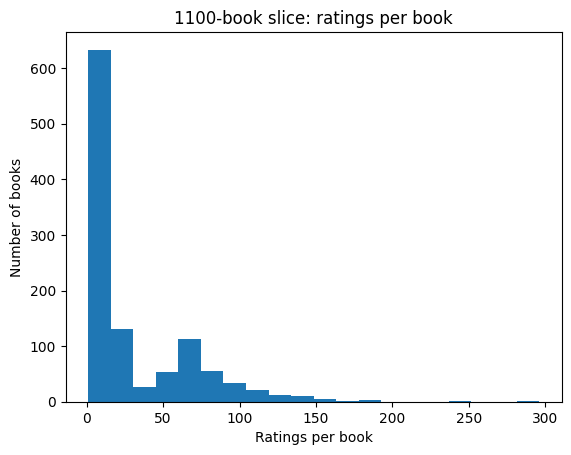

In [10]:
print("\nCalculating long-tail distribution...")
bc_df = final_slice.groupBy("ISBN").count().orderBy(F.desc("count"))

# Collect the result to the driver as a pandas DataFrame
bc_pandas_df = bc_df.toPandas()

# Now, use the pandas logic for plotting
cum = bc_pandas_df['count'].cumsum() / bc_pandas_df['count'].sum()
n80 = (cum <= 0.8).sum()

#The denominator is the total number of unique books in the slice
total_books = len(bc_pandas_df)
print(f"{n80}/{total_books} books cover 80% → {n80/total_books:.1%}")

# Plotting using matplotlib
plt.hist(bc_pandas_df['count'].values, bins=20)
plt.title(f"{total_books}-book slice: ratings per book")
plt.xlabel("Ratings per book")
plt.ylabel("Number of books")
plt.show()

In [90]:
final_slice

DataFrame[ISBN: string, User-ID: int, Book-Rating: int, userIntId: bigint, bookIntId: bigint]

## Collaborative Filtering Spark Model (ALS)

Spark's main collaborative filtering model is `pyspark.ml.recommendation.ALS`. ALS is used instead of SVD since unlike SVD, ALS is conducive to breaking down into parallel processing.

In [11]:
# Focus on userIntId, bookIntId, and Book-Rating for Spark ALS
ratings = final_slice.select(col("userIntId").alias("userId"), col("bookIntId").alias("bookId"), col("Book-Rating").alias("rating"))
display(ratings.show())

+------+------+------+
|userId|bookId|rating|
+------+------+------+
|   361|  3508|     0|
|   361|  9200|     0|
|   361| 16978|     0|
|   597| 20532|     0|
|   597| 29015|     0|
|   361| 30793|     0|
|   361| 34093|     0|
|   361| 42659|     0|
|   361| 44285|     0|
|   361| 44595|     0|
|   361| 58020|     9|
|   597| 59814|     0|
|   361| 61527|     0|
|   361| 73337|     0|
|   597| 75044|     0|
|   361| 76800|     0|
|   361| 81917|     0|
|   361| 85612|     0|
|   361| 85371|     0|
|   361| 88913|     0|
+------+------+------+
only showing top 20 rows


None

### Create training and test data

In [33]:
# Split the ratings into training and test data
(training_data, test_data) = ratings.randomSplit([0.7, 0.3], seed=42)
test_data_cached = test_data.cache()
training_data_cached = training_data.cache()

25/07/03 17:36:03 WARN CacheManager: Asked to cache already cached data.


According to Spark's documentation, here is a breakdown of `ALS`'s parameters:
* numBlocks is the number of blocks the users and items will be partitioned into in order to parallelize computation (defaults to 10).
* rank is the number of latent factors in the model (defaults to 10).
* maxIter is the maximum number of iterations to run (defaults to 10).
* regParam specifies the regularization parameter in ALS (defaults to 1.0).
* implicitPrefs specifies whether to use the explicit feedback ALS variant or one adapted for implicit feedback data (defaults to false which means using explicit feedback).
* alpha is a parameter applicable to the implicit feedback variant of ALS that governs the baseline confidence in preference observations (defaults to 1.0).
* nonnegative specifies whether or not to use nonnegative constraints for least squares (defaults to false).

### ALS Model (No Tuning)

In [13]:
# Set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
als = ALS(userCol="userId", itemCol="bookId", ratingCol="rating", rank = 10, maxIter = 15, regParam = .1,
          coldStartStrategy="drop", nonnegative = True, implicitPrefs = False)

# Fit the model to the training_data
model = als.fit(training_data_cached)

# Generate predictions on the test_data
test_predictions = model.transform(test_data_cached)

25/07/03 16:00:49 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


In [14]:
display(test_predictions.show())

+------+------+------+-----------+
|userId|bookId|rating| prediction|
+------+------+------+-----------+
| 18051|  8528|     0|  0.6802998|
| 18051| 24009|     0| 0.83428943|
| 18051| 47736|     0| 0.14481975|
| 18051| 51450|     0|        0.0|
| 18051| 58012|     0| 0.41821975|
| 18051| 93904|     0|  0.1736164|
| 18051|107566|     0| 0.14929721|
| 18051|109275|     0| 0.77849776|
| 18051|160114|     0|0.061431136|
| 72702|104196|     0|  4.8583765|
| 92317|  8565|     6|   4.105564|
| 92317| 25664|     9|  0.7474311|
| 92317| 76800|     0|  1.5671599|
|166150| 95621|     0| 0.64720666|
|251529|  3479|     0|  1.1429398|
|251529|109275|     0| 0.42575198|
|251529|129512|     0|  1.6466571|
|251529|134549|     0|        0.0|
|251529|166985|     0|   5.621513|
| 36982|166989|     0|   6.625345|
+------+------+------+-----------+
only showing top 20 rows


### Hyperparamter Tuning

In [34]:
# Hyperparameter tuning

param_grid = ParamGridBuilder() \
           .addGrid(als.rank, [10, 50, 75, 100]) \
           .addGrid(als.maxIter, [10]) \
           .addGrid(als.regParam, [.05, .1, .15]) \
           .build()

# Create RMSE evaluator
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

# Use cross validation
cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5, collectSubModels=True)

# Checkpoint the training data to truncate its lineage.
# This is a lazy operation, it will be triggered by the .fit() call.
training_data_chkp = training_data_cached.checkpoint()

# Fit the cross validator on the CHECKPOINTED DataFrame.
model = cv.fit(training_data_chkp)

# Best model
best_model = model.bestModel

# Average RMSE for each model
avg_rmse_models = model.avgMetrics

display(f"{len(param_grid)} models tested")

'12 models tested'

### Tuning Graphs

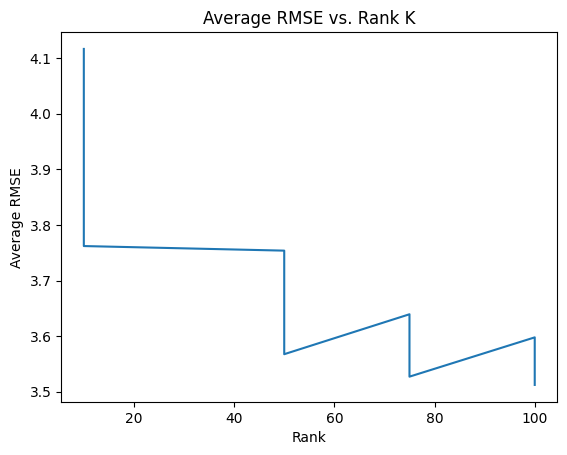

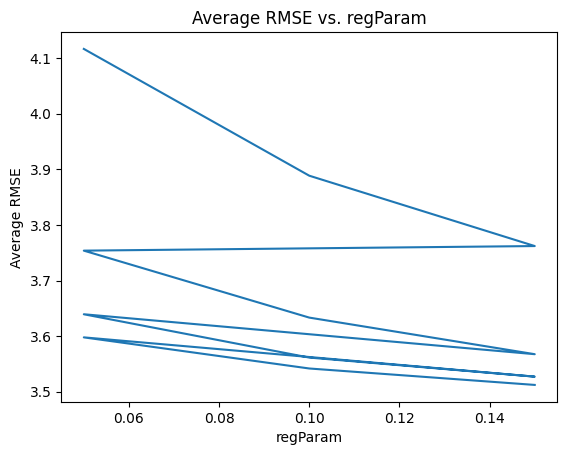

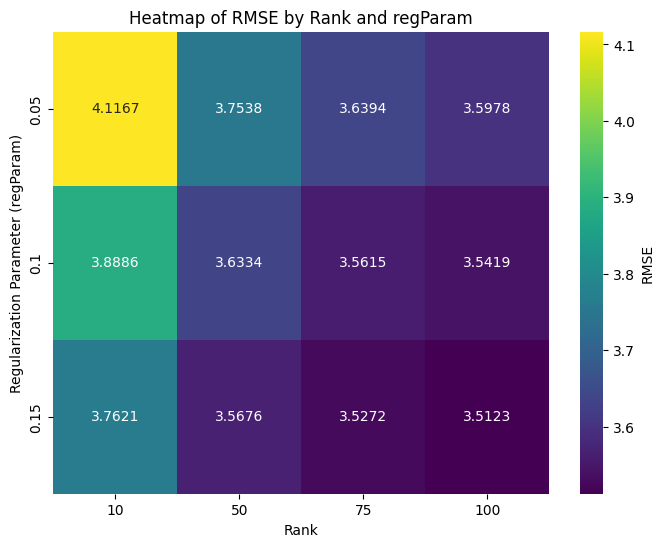

In [70]:
# Graphs

ranks = []
reg_params = []
for dict in cv.getEstimatorParamMaps():
    for param in dict.keys():
        if param.name == 'rank':
            rank_param = param
            ranks.append(dict[rank_param])
        if param.name == 'regParam':
            reg_param = param
            reg_params.append(dict[reg_param])

data = {
    'rmse': avg_rmse_models,
    'rank': ranks,
    'regParam': reg_params
}

als_results_df = pd.DataFrame(data)

als_results_df_grouped = als_results_df.groupby(['rank', 'regParam']).agg(
    avg_rmse=('rmse', 'mean')
).reset_index()

plt.plot(als_results_df_grouped['rank'], als_results_df_grouped['avg_rmse'])
plt.xlabel("Rank")
plt.ylabel("Average RMSE")
plt.title("Average RMSE vs. Rank K")
plt.show()

plt.plot(reg_params, avg_rmse_models)
plt.xlabel("regParam")
plt.ylabel("Average RMSE")
plt.title("Average RMSE vs. regParam")
plt.show()

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


als_results_df_grouped_pivot = als_results_df_grouped.pivot(index='regParam', columns='rank', values='avg_rmse')

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(als_results_df_grouped_pivot, annot=True, fmt=".4f", cmap='viridis', cbar_kws={'label': 'RMSE'})
plt.title('Heatmap of RMSE by Rank and regParam')
plt.xlabel('Rank')
plt.ylabel('Regularization Parameter (regParam)')
plt.show()


### Best ALS Model

In [57]:
display(f"Best Model Rank: {best_model.rank}")
display(f"Best Model Params: {best_model.params}")

'Best Model Rank: 100'

'Best Model Params: [Param(parent=\'ALS_7d6fb1ce1a98\', name=\'blockSize\', doc=\'block size for stacking input data in matrices. Data is stacked within partitions. If block size is more than remaining data in a partition then it is adjusted to the size of this data.\'), Param(parent=\'ALS_7d6fb1ce1a98\', name=\'coldStartStrategy\', doc="strategy for dealing with unknown or new users/items at prediction time. This may be useful in cross-validation or production scenarios, for handling user/item ids the model has not seen in the training data. Supported values: \'nan\', \'drop\'."), Param(parent=\'ALS_7d6fb1ce1a98\', name=\'itemCol\', doc=\'column name for item ids. Ids must be within the integer value range.\'), Param(parent=\'ALS_7d6fb1ce1a98\', name=\'predictionCol\', doc=\'prediction column name.\'), Param(parent=\'ALS_7d6fb1ce1a98\', name=\'userCol\', doc=\'column name for user ids. Ids must be within the integer value range.\')]'

### Test Data RMSE

In [75]:
# test_data_cached = test_data.cache()
test_predictions = best_model.transform(test_data_cached)
test_predictions_cached = test_predictions.cache()

# Calculate the RMSE of test_predictions
rmse = evaluator.evaluate(test_predictions_cached)
display(rmse)

3.5193537170930855

### Make Predictions

In [87]:
user_counts = ratings.filter(col("rating") != 0).groupBy("userId").count().withColumnRenamed("count", "user_rating_count")
user_counts.show()

+------+-----------------+
|userId|user_rating_count|
+------+-----------------+
| 64317|                5|
| 84120|               26|
|115457|                7|
|133164|               10|
|171782|                8|
|173929|               20|
| 42653|                2|
| 45956|               10|
|188225|                8|
|271837|                6|
| 39524|                7|
| 57248|                6|
|268472|                1|
|273016|                1|
|278792|                1|
|164189|                5|
|176844|                5|
|211490|               12|
| 80707|                4|
| 90766|               11|
+------+-----------------+
only showing top 20 rows


In [100]:
def make_als_prediction(test_predictions, userId):
    already_seen_movies = ratings.filter((col("userId") == userId) & (col("rating") != 0))
    als_user_predictions = test_predictions.filter(col("userId") == userId)
    final_df = als_user_predictions.join(already_seen_movies, "bookId", "left_anti")
    return final_df.sort(final_df.prediction.desc())

als_user_predictions = make_als_prediction(test_predictions_cached, 84120)
als_user_predictions.show()

+------+------+------+----------+
|bookId|userId|rating|prediction|
+------+------+------+----------+
| 27305| 84120|     0| 9.2345705|
| 30682| 84120|     0| 7.0612874|
| 16991| 84120|     0|  4.456969|
| 30692| 84120|     0|  4.349996|
| 80191| 84120|     0|  4.347192|
|224938| 84120|     0| 3.3740413|
|241959| 84120|     0| 3.2472444|
|231748| 84120|     0| 2.4069738|
|197638| 84120|     0| 2.1862333|
|338899| 84120|     0| 1.8425243|
|178854| 84120|     0| 1.4025521|
|134548| 84120|     0| 1.1569939|
|179072| 84120|     0|0.87449855|
| 54569| 84120|     0|0.55811936|
+------+------+------+----------+



In [ ]:
 #spark.stop()

## Conclusion

In [18]:
# GITHUB_RAW_BASE = "https://raw.githubusercontent.com/farhodibr/PROJECT5/main"
# SINGLE_URL      = f"{GITHUB_RAW_BASE}/book_metadata/metadata_all.csv"
# PARTS_URL_FMT   = f"{GITHUB_RAW_BASE}/book_metadata_parts/metadata_part_{{}}.csv"
#
# OUTPUT_DIR      = "book_metadata_parts"
# os.makedirs(OUTPUT_DIR, exist_ok=True)
#
# # test if a raw GitHub URL exists
# def remote_exists(url: str) -> bool:
#     try:
#         return requests.head(url, timeout=5).status_code == 200
#     except requests.RequestException:
#         return False
#
# final_schema = StructType([
#     StructField("ISBN",             StringType(), True),
#     StructField("title",            StringType(), True),
#     StructField("description",      StringType(), True),
#     StructField("authors",          StringType(), True),
#     StructField("publish_date",     StringType(), True),
#     StructField("publisher",        StringType(), True),
#     StructField("number_of_pages",  IntegerType(), True),
#     StructField("subjects",         StringType(), True)
# ])
#
# # Try loading the single combined CSV from GitHub
# if remote_exists(SINGLE_URL):
#     print("✅ Found metadata_all.csv on GitHub. Loading via pandas → Spark.")
#     pdf = pd.read_csv(SINGLE_URL)
#     # ensure integer pages
#     pdf['number_of_pages'] = pdf['number_of_pages'].fillna(0).astype(int)
#     metadata_df = (
#         spark.createDataFrame(pdf, schema=final_schema)
#              .cache()
#     )
#
# # Else try loading numbered parts from GitHub
# elif remote_exists(PARTS_URL_FMT.format(1)):
#     print("found metadata parts on GitHub. Loading all parts via pandas → Spark.")
#     parts_urls = []
#     i = 1
#     while remote_exists(PARTS_URL_FMT.format(i)):
#         parts_urls.append(PARTS_URL_FMT.format(i))
#         i += 1
#
#     pdfs = []
#     for url in parts_urls:
#         part = pd.read_csv(url)
#         part['number_of_pages'] = part['number_of_pages'].fillna(0).astype(int)
#         pdfs.append(part)
#
#     all_pdf = pd.concat(pdfs, ignore_index=True).drop_duplicates("ISBN")
#     metadata_df = (
#         spark.createDataFrame(all_pdf, schema=final_schema)
#              .cache()
#     )
#
# #Otherwise fall back to fetching via Google Books API
# else:
#     print("No GitHub metadata found. Fetching via Google Books API…")
#     GOOGLE_API_KEY = ""
#     if not GOOGLE_API_KEY:
#         raise RuntimeError("Please set the GOOGLE_BOOKS_API_KEY env var.")
#
#     def build_url(isbn: str) -> str:
#         return (
#             f"https://www.googleapis.com/books/v1/volumes"
#             f"?q=isbn:{isbn}&key={GOOGLE_API_KEY}"
#         )
#
#     def fetch_single_book_metadata(isbn, max_retries=3, initial_delay=1):
#         url   = build_url(isbn)
#         delay = initial_delay
#         for attempt in range(1, max_retries+1):
#             resp = requests.get(url, timeout=15)
#             if resp.status_code == 429:
#                 ra   = resp.headers.get("Retry-After")
#                 wait = float(ra) if ra else delay
#                 print(f"[429] {isbn}, retry {attempt}/{max_retries} in {wait}s")
#                 time.sleep(wait)
#                 delay *= 2
#                 continue
#             try:
#                 resp.raise_for_status()
#                 data = resp.json()
#             except Exception as e:
#                 print(f"[ERROR] {isbn} attempt {attempt}: {e}")
#                 time.sleep(delay)
#                 delay *= 2
#                 continue
#             items = data.get("items")
#             if not items:
#                 return {"ISBN": isbn}
#             info  = items[0].get("volumeInfo", {})
#             pages = info.get("pageCount")
#             try:
#                 pages = int(pages) if pages is not None else 0
#             except:
#                 pages = 0
#             time.sleep(0.3)
#             return {
#                 "ISBN":            isbn,
#                 "title":           info.get("title", ""),
#                 "description":     info.get("description", ""),
#                 "authors":         ", ".join(info.get("authors", [])),
#                 "publish_date":    info.get("publishedDate", ""),
#                 "publisher":       info.get("publisher", ""),
#                 "number_of_pages": pages,
#                 "subjects":        ", ".join(info.get("categories", []))
#             }
#         print(f"[FAILED] ISBN {isbn} after {max_retries} attempts.")
#         return {"ISBN": isbn, "number_of_pages": 0}
#
#     def chunker(seq, size):
#         for i in range(0, len(seq), size):
#             yield seq[i:i+size]
#
#     isbn_list = [r.ISBN for r in final_slice.select("ISBN").distinct().collect()]
#     batches   = list(chunker(isbn_list, 100))
#
#     all_results = []
#     for idx, batch in enumerate(batches, 1):
#         print(f"Batch {idx}/{len(batches)}: fetching {len(batch)} ISBNs…")
#         with ThreadPoolExecutor(max_workers=2) as exe:
#             futures = [exe.submit(fetch_single_book_metadata, isbn) for isbn in batch]
#             for fut in as_completed(futures):
#                 all_results.append(fut.result())
#         time.sleep(10)
#
#     # save and load via Spark
#     local_csv = f"{OUTPUT_DIR}/metadata_all_local.csv"
#     pd.DataFrame(all_results).to_csv(local_csv, index=False)
#     metadata_df = (
#         spark.read
#              .schema(final_schema)
#              .option("header", True)
#              .csv(local_csv)
#              .cache()
#     )
#
#
# print("Metadata schema:")
# metadata_df.printSchema()
#
# preview_cols = ["ISBN", "title", "authors", "publish_date", "number_of_pages"]
#
# print("Sample metadata (subset of columns):")
# print(pdf[preview_cols]
#       .head(5)
#       .to_string(index=False))
#
# print("\n Description snippet (first 150 chars):")
# snippet = pdf[["ISBN", "description"]].copy()
# snippet["desc_snippet"] = snippet["description"].str.slice(0, 150)
# print(snippet[["ISBN", "desc_snippet"]]
#       .head(5)
#       .to_string(index=False))


In [19]:
# from pyspark.sql import SparkSession
# import os
#
# # Define a compatible set of versions
# spark_nlp_version = "5.3.3" # A stable version for Spark 3.5.x
# spark_version_scope = "3.5"
# nlp_package = f"com.johnsnowlabs.nlp:spark-nlp-spark{spark_version_scope}_2.12:{spark_nlp_version}"
#
# print(f"Configuring Spark Session to use Spark NLP package: {nlp_package}")
#
# # Stop any existing session to ensure a clean start
# try:
#     SparkSession.builder.getOrCreate().stop()
#     print("Stopped existing Spark session.")
# except:
#     pass
#
# # Build a new session with the correct Spark NLP package included
# spark = SparkSession.builder \
#     .appName("SparkNLP_Book_Recommender") \
#     .master("local[*]") \
#     .config("spark.driver.memory", "16G") \
#     .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
#     .config("spark.kryoserializer.buffer.max", "2000M") \
#     .config("spark.driver.maxResultSize", "0") \
#     .config("spark.jars.packages", nlp_package) \
#     .getOrCreate()
#
# print("Spark session configured and started successfully.")
#
# import pyspark.sql.functions as F
# from pyspark.sql import DataFrame
# from pyspark.sql.types import StructType, StructField, StringType, IntegerType
# from pyspark.ml import Pipeline
#
# import sparknlp
# from sparknlp.base import *
# from sparknlp.annotator import UniversalSentenceEncoder
# from pyspark.ml.feature import Normalizer, BucketedRandomProjectionLSH
#
# print("\n--- Content-Based Recommender Setup ---")
# print(f"Spark NLP version: {sparknlp.version()}")
# print(f"Apache Spark version: {spark.version}")
#
#
# metadata_url = "https://raw.githubusercontent.com/farhodibr/PROJECT5/main/book_metadata/metadata_all.csv"
# spark.sparkContext.addFile(metadata_url)
#
# # Now, we can read the file from the path provided by SparkFiles
# metadata_filename = os.path.basename(metadata_url)
# metadata_path = SparkFiles.get(metadata_filename)
#
# if not os.path.exists(metadata_path):
#     print(f"ERROR: '{metadata_path}' not found. Please ensure the file is in the correct directory.")
# else:
#     final_schema = StructType([
#         StructField("ISBN", StringType(), True),
#         StructField("title", StringType(), True),
#         StructField("description", StringType(), True),
#         StructField("authors", StringType(), True),
#         StructField("publish_date", StringType(), True),
#         StructField("publisher", StringType(), True),
#         StructField("number_of_pages", IntegerType(), True),
#         StructField("subjects", StringType(), True)
#     ])
#
#     metadata_df = (
#         spark.read
#              .schema(final_schema)
#              .option("header", True)
#              .csv(metadata_path)
#              .na.fill({"title": "No Title", "description": "No Description"}) # Handle potential nulls
#              .cache()
#     )
#     print("✅ Book metadata loaded successfully.")
#     metadata_df.select("ISBN", "title").show(5, truncate=False)
#
#     # We will convert book titles and descriptions into numerical vectors (embeddings).
#     # Combine title and description into a single feature column
#     df_for_nlp = metadata_df.withColumn(
#         "text",
#         F.concat_ws(" ", F.col("title"), F.col("description"))
#     ).filter(F.col("text") != "No Title No Description")
#
#     # Define the Spark NLP pipeline stages
#     document_assembler = DocumentAssembler() \
#         .setInputCol("text") \
#         .setOutputCol("document")
#
#     use = UniversalSentenceEncoder.pretrained() \
#         .setInputCols(["document"]) \
#         .setOutputCol("sentence_embeddings")
#
#     finisher = Finisher() \
#         .setInputCols(["sentence_embeddings"]) \
#         .setOutputCols(["finished_embeddings"]) \
#         .setOutputAsVector(True)
#
#     nlp_pipeline = Pipeline(stages=[document_assembler, use, finisher])
#
#     # Generate the embeddings
#     print("\nGenerating book embeddings with Spark NLP (this may take a few minutes)...")
#     embeddings_df = nlp_pipeline.fit(df_for_nlp).transform(df_for_nlp)
#
#     # Extract the vector from the finished array
#     embeddings_df = embeddings_df.withColumn("embedding", F.col("finished_embeddings")[0])
#     print("✅ Embeddings generated.")
#
#
#     # Use LSH to Find Similar Books
#     # Locality Sensitive Hashing (LSH) is an efficient way to find nearest neighbors.
#
#     # Normalize embeddings for LSH
#     normalizer = Normalizer(inputCol="embedding", outputCol="norm_embedding", p=2.0)
#     normalized_df = normalizer.transform(embeddings_df)
#
#     # Create and train the LSH model
#     brp = BucketedRandomProjectionLSH(
#         inputCol="norm_embedding",
#         outputCol="hashes",
#         bucketLength=2.0,
#         numHashTables=5
#     )
#
#     print("\nTraining Locality Sensitive Hashing (LSH) model...")
#     lsh_model = brp.fit(normalized_df)
#     print("✅ LSH model trained.")
#
#
#     # Create the Recommendation Function
#     # This function takes a book title and finds similar books.
#
#     def get_content_based_recs(book_title: str, num_recs: int = 10) -> DataFrame:
#         """
#         Finds and returns content-based book recommendations for a given book title.
#         """
#         print("\n" + "="*50)
#         print(f"Finding recommendations for: '{book_title}'")
#         print("="*50)
#
#         try:
#             # Find the embedding vector for the input book
#             book_embedding = normalized_df.filter(F.col("title") == book_title).first()["norm_embedding"]
#         except (TypeError, IndexError):
#             print(f"Could not find the book '{book_title}' in the dataset.")
#             return spark.createDataFrame([], schema="title STRING, authors STRING, distance FLOAT")
#
#         # Use the LSH model to find the most similar items
#         print(f"Searching for the top {num_recs} most similar books...")
#         recommendations_df = lsh_model.approxNearestNeighbors(normalized_df, book_embedding, num_recs + 1)
#
#         # Format and display the results
#         recs = recommendations_df.select("title", "authors", F.col("distCol").alias("distance")) \
#                                  .filter(F.col("title") != book_title) \
#                                  .orderBy("distance")
#
#         if recs.count() == 0:
#             print("No similar books found.")
#         else:
#             print("\n--- Recommendations ---")
#             recs.show(num_recs, truncate=False)
#
#         return recs
#
#     # -
#     # test content-based recommender directly.
#     lost_world_recs = get_content_based_recs("The Lost World")
#     beach_recs = get_content_based_recs("The Beach")
#
